In [1]:
# Do a time series data analysis and apply Kmeans++ and adtk tools to do anomaly detection on the data below
# The dataset can be found here: https://www.kaggle.com/boltzmannbrain/nab 
# Save this dataset to the working folder of your notebook as: "ambient_temperature_system_failure.csv" 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv("ambient_temperature_system_failure.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [3]:
print(df.head(10)) # view the first few instances of the data, the data is made for a value for each hour 
# convert the data type from object to time series
# print(df['timestamp'].dtype) # data type of the values under timestamp attribute is object
df['date'] = pd.to_datetime(df['timestamp']) # converting the timestamp object to pd time series
print(type(df['date'])) # time series
df_timeseries = df.copy() # to be used later

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551
5  2013-07-04 05:00:00  70.060966
6  2013-07-04 06:00:00  69.279765
7  2013-07-04 07:00:00  69.369608
8  2013-07-04 08:00:00  69.166714
9  2013-07-04 09:00:00  68.986083
<class 'pandas.core.series.Series'>


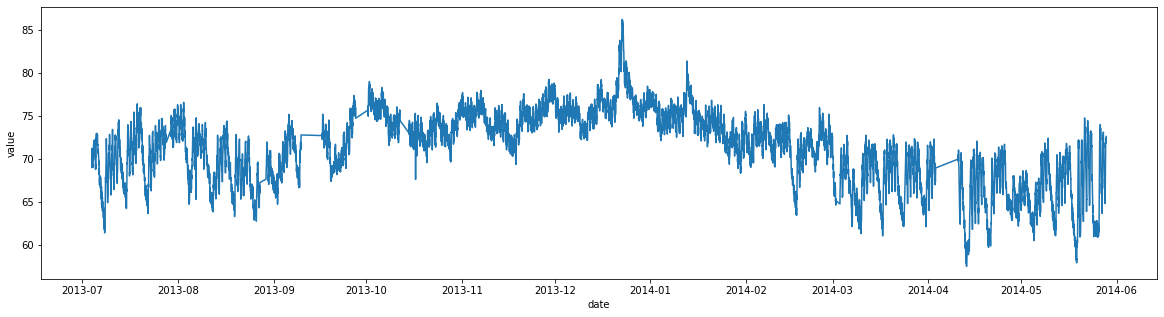

In [4]:
plt.figure(figsize=(20,5))
sns.lineplot(x = df['date'], y = df['value']) # view the whole dataset in one chart

In [5]:
df_timeseries.isna().sum()
# there are no missing values, however there are some measurements forming unusual patterns such as 2013's 09-10 etc.

timestamp    0
value        0
date         0
dtype: int64

4.247217158777425 71.24243270828815
99


(array([55., 15.,  0.,  0.,  0.,  0.,  0.,  0., 14., 15.]),
 array([57.45840559, 60.33488629, 63.21136699, 66.0878477 , 68.9643284 ,
        71.8408091 , 74.7172898 , 77.5937705 , 80.47025121, 83.34673191,
        86.22321261]),
 <a list of 10 Patch objects>)

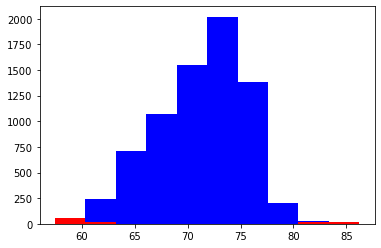

In [6]:
# WITHOUT considering the normal changes in season, weekdays, weekends, holidays, and the time of the day: day/night:
# One easy way to visualize abnormality is to assume that the data fits into a gaussian and whatever the data is far
# from the mean is considered as abnormality. This is only valid for the data that actually has a great g. distribution

values = np.array(df['value'])
plt.hist(values, color = 'b')
std = values.std()
mean = values.mean()

# Anomaly could be 1, 2, or 3 times of std deviation or a constant*variance away from the mean, depending on the data.
print(std, mean)
values_above_and_below_normal = [i for i in values if i < mean-2.5*std or i > mean+2.5*std]
print(len(values_above_and_below_normal))
plt.hist(values_above_and_below_normal, color = 'r')

# The abnormalities which is when the temperature is too cold and too hot are shown below in red color
# The data is not a very good gaussian distribution. 

# Conclusion: Data needs to be analyzed after it is expanded to multiple attributes.
# Reminder: There are 7267 entries. 

In [7]:
# Visualize the data after breaking it into several categories with .dt.strftime() function;
# Ex: '%B %d, %Y, %r' ==> %B:April %d:10, %Y:2019, %r:09:00:00 AM ==> 'April 10, 2019, 09:00:00 AM'

df['month'] = df['date'].dt.strftime('%B')  # %B is month
df['year'] = df['date'].dt.strftime('%Y')   # %Y is year
df['dayofweek'] = df['date'].dt.strftime('%A') # A is day of the week
df['quarter'] = df['date'].dt.quarter 
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.dayofweek
df['weekofyear'] = df['date'].dt.isocalendar().week

# For later use, store data and labels
X = df.drop(['value', 'date' , 'timestamp'], axis = 1)
y = df['value']
df_new = pd.concat([X, y], axis=1)

# View if data and labels are ready to analyze
df_new.head()

,month,year,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,value
0,July,2013,Thursday,3,185,3,27,69.880835
1,July,2013,Thursday,3,185,3,27,71.220227
2,July,2013,Thursday,3,185,3,27,70.877805
3,July,2013,Thursday,3,185,3,27,68.959400
4,July,2013,Thursday,3,185,3,27,69.283551


In [8]:
# check if there is any none values exist in the data
df_new.isna().sum()

month         0
year          0
dayofweek     0
quarter       0
dayofyear     0
dayofmonth    0
weekofyear    0
value         0
dtype: int64

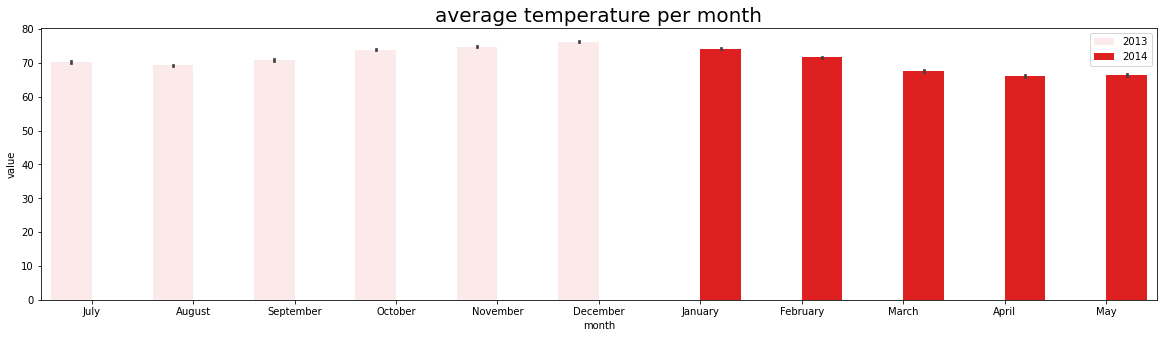

In [9]:
# visualize the data by month vs mean temperature
plt.figure(figsize=(20,5))
a = sns.barplot(x="month", y="value", hue = 'year', color = 'red' , data = df_new)
a.set_title("average temperature per month",fontsize=20)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Average Temperature By year')

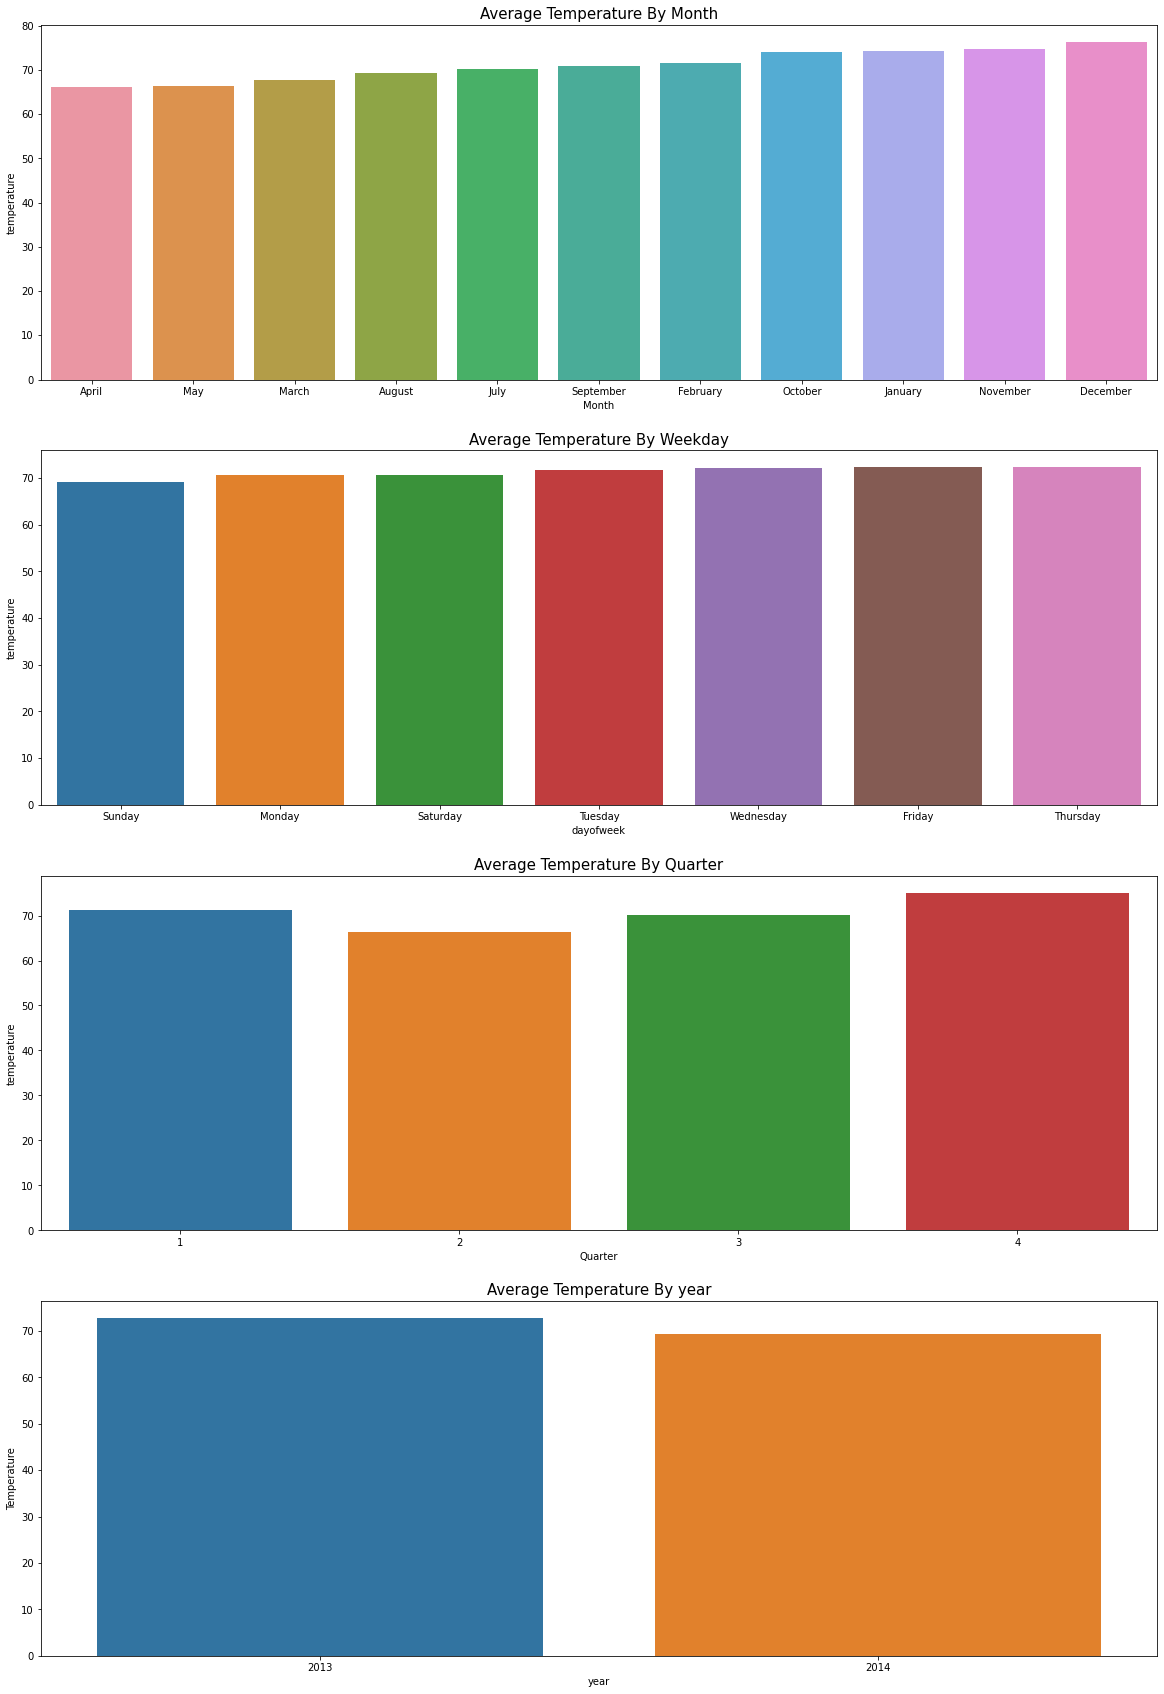

In [10]:
# visualize the data with matplot library:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

temp_per_month = pd.DataFrame(df_new.groupby("month")["value"].mean()).reset_index().sort_values('value')
sns.barplot(data=temp_per_month,x="month",y="value",ax=ax1)
ax1.set(xlabel='Month', ylabel='temperature')
ax1.set_title("Average Temperature By Month",fontsize=15)

temp_per_weekday = pd.DataFrame(df_new.groupby("dayofweek")["value"].mean()).reset_index().sort_values('value')
sns.barplot(data=temp_per_weekday,x="dayofweek",y="value",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='temperature')
ax2.set_title("Average Temperature By Weekday",fontsize=15)

temp_per_quarter = pd.DataFrame(df_new.groupby("quarter")["value"].mean()).reset_index().sort_values('value')
sns.barplot(data=temp_per_quarter,x="quarter",y="value",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='temperature')
ax3.set_title("Average Temperature By Quarter",fontsize=15)

temp_per_year = pd.DataFrame(df_new.groupby("year")["value"].mean()).reset_index().sort_values('value')
sns.barplot(data=temp_per_year,x="year",y="value",ax=ax4)
ax4.set(xlabel='year', ylabel='Temperature')
ax4.set_title("Average Temperature By year",fontsize=15)


In [11]:
# Conclusion: The data does not show any good separation or a base for a clustering algorithms so far
# Next: Do day time vs night time, weekday vs weekend comparisions and may be hourly comparisions.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   7267 non-null   object        
 1   value       7267 non-null   float64       
 2   date        7267 non-null   datetime64[ns]
 3   month       7267 non-null   object        
 4   year        7267 non-null   object        
 5   dayofweek   7267 non-null   object        
 6   quarter     7267 non-null   int64         
 7   dayofyear   7267 non-null   int64         
 8   dayofmonth  7267 non-null   int64         
 9   weekofyear  7267 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 546.6+ KB


In [12]:
# create a brand new df
df['dayofyear'] = df['date'].dt.dayofyear 
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.dayofweek.astype(int)
df['weekend'] = (df['day'] > 5).astype(int)*0.001
df['daylight'] = ((df['hour'] >= 7) & (df['hour'] <= 18)).astype(int)*0.001
df_week_and_day = df[['dayofyear', 'day', 'daylight','weekend', 'value']]
df_week_and_day.info()
df_week_and_day.head(10)
# we are adding a very very small bias and converting the text values into float to do a clustering. 
# the daylight is assumed to have higher temp as well as the weekends

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dayofyear  7267 non-null   int64  
 1   day        7267 non-null   int64  
 2   daylight   7267 non-null   float64
 3   weekend    7267 non-null   float64
 4   value      7267 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 284.0 KB


,dayofyear,day,daylight,weekend,value
0,185,3,0.000,0.0,69.880835
1,185,3,0.000,0.0,71.220227
2,185,3,0.000,0.0,70.877805
3,185,3,0.000,0.0,68.959400
4,185,3,0.000,0.0,69.283551
5,185,3,0.000,0.0,70.060966
6,185,3,0.000,0.0,69.279765
7,185,3,0.001,0.0,69.369608
8,185,3,0.001,0.0,69.166714
9,185,3,0.001,0.0,68.986083


[     0.    131088.352  42308.813  21904.349  14003.767   9940.356
   7395.793   5556.248   4246.255   3388.203   2702.44    2321.026
   1962.395   1651.473   1441.012]


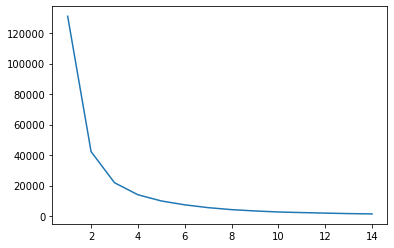

In [13]:
# Write a kmeans plus plus algorithm to initialize the centroids to be used in the kmeans algorithm
# Initialize centroids based on a probability index set by their distance from each other


dataset = np.array(df_week_and_day[['daylight','weekend','value']]) # Dataset is a numpy array and k is # of centroids
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_plus_plus(dataset, k):
    # define the shape of the dataset
    N, D = dataset.shape
    # define the centroid size
    C = np.zeros([k, D])
    # pick a random instance in the dataset
    random_index = np.random.choice(len(dataset))
    # choose a random instance
    random_instance = dataset[random_index]
    for i in range(k):
        # define the distance array to store all items in the dataset from the randomly chosen instance
        distance_array = np.linalg.norm(random_instance - dataset , axis = 1)
        # each distance proportionally increase the chances for the next data to be chosen
        prob_array = distance_array / np.sum(distance_array)
        # based on the distances, chose a random instance index
        chosen_index = np.random.choice(len(dataset) , p = prob_array)
        # assing the next instance to the centroid[i]
        C[i] = dataset[chosen_index]
        # last chosen C[i] will be the new reference to chose next instance for C[i+1]
        random_instance = C[i]  
    return C



def k_means(dataset, k): # return the WCSS value for chosen k clusters
    # Initialize the WCSS value to 0
    WCSS = 0
    # create an array to collect the indices of the groups
    final_array = np.zeros(len(dataset))
    # initialize the centroids based on the kmeansplusplus function. If data is too big, just choose k random instances
    C = kmeans_plus_plus(dataset, k)
    # create an old C initialized with zeros
    C_old = np.zeros(C.shape)
    # define the error function
    parameter_gradient = np.linalg.norm(C-C_old)
    # count the number of epochs performed until the error is zero, put an iterator
    epoch = 0
    # continue to assign new C until the distance btw C_new and C_old is very small
    while parameter_gradient > 1e-4:  
        # loop over the dataset to measure the instance distances with C
        # assign the group number for each instance based on the shortest distance from the instance to the C
        for i in range(len(dataset)):
            distance = np.linalg.norm((dataset[i] - C), axis = 1) # axis 1 will output distance array with size k
            centroid_index = np.argmin(distance) # the closest centroid_index from the instance 
            final_array[i] = centroid_index # assign the centroid index as group number to an array 
        # assign the current C as C_old to update the new C
        C_old = np.copy(C)
        # loop over each index of the centroid
        for i in range(k):
            # list of items with the same group numbers are assigned to sub_groups
            sub_group = [dataset[j] for j in range(len(dataset)) if final_array[j] == i]
            # take the mean of the sub-group and 
            mean_of_sub_group = np.mean(sub_group, axis = 0)
            # assign the new values to C
            C[i] = mean_of_sub_group
        # update the parameter gradient after assigning the new C    
        parameter_gradient = np.linalg.norm(C - C_old) # when C does not change, we reach to zero error 
        # update epoch value
        epoch += 1

    # To measure WCSS, sum up the square of the "distances from all group data to their mean"
    for j in range(k):
        grouped_data = [dataset[i] for i in range(len(dataset)) if final_array[i] == j]
        mean_of_grouped_data = np.mean(grouped_data, axis = 0) # outputs number of attributes
        for i in range(len(grouped_data)):
            WCSS += np.sum((grouped_data[i] - mean_of_grouped_data)**2)  
            
    
    # return the final cluster coordinates, the array carrying indices of all data points, and the WCSS with given k
    return epoch, C, final_array, WCSS


# normalize the dataset before clustering
# dataset = dataset/np.linalg.norm(dataset, ord=2, axis=1, keepdims=True)
# fix a random seed for picking the centroids
np.random.seed(1)
k = 15
def run_k_means():
    WCSS_list = np.zeros(k)
    for i in range(1, k):
        epoch, C, final_array, WCSS = k_means(dataset, i)
        WCSS_list[i] = WCSS

    return WCSS_list

result = run_k_means()
print(result)
plt.plot(np.arange(1, k), result[1:])
    

In [14]:
# 3 clusters to analyze the data seems like a good approach
epoch, C, final_array, WCSS = k_means(dataset, 3)
# final_array can be arranged in 3 clusters
for j in range(3):
    first_cluster = np.array([dataset[i] for i in range(len(dataset)) if final_array[i] == 0])
    second_cluster = np.array([dataset[i] for i in range(len(dataset)) if final_array[i] == 1])
    third_cluster = np.array([dataset[i] for i in range(len(dataset)) if final_array[i] == 2])
    

70.86149441358569 75.38348706130851 65.09699959218446
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2906 non-null   float64
 1   1       2906 non-null   float64
 2   2       2906 non-null   float64
dtypes: float64(3)
memory usage: 68.2 KB
          1     2
0                
0.000  1301  1301
0.001  1605  1605
          0     2
1                
0.000  2660  2660
0.001   246   246
          1     2
0                
0.000  1466  1466
0.001  1247  1247
          0     2
1                
0.000  2437  2437
0.001   276   276
         1    2
0              
0.000  870  870
0.001  778  778
          0     2
1                
0.000  1178  1178
0.001   470   470


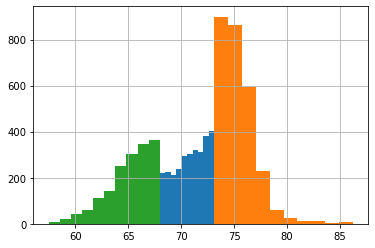

In [15]:
# find out the differences of the clusters, there is a slight difference of these clusters mean values
print(first_cluster[:,2].mean(), second_cluster[:,2].mean(), third_cluster[:,2].mean())
# categorize the first 3 index into a value
df1 = pd.DataFrame(first_cluster)
df2 = pd.DataFrame(second_cluster)
df3 = pd.DataFrame(third_cluster)
df1.info()
print(df1.groupby([0]).count())
print(df1.groupby([1]).count())
print(df2.groupby([0]).count())
print(df2.groupby([1]).count())
print(df3.groupby([0]).count())
print(df3.groupby([1]).count())
# as it is seen grouping by day or night (column 0) is not as effective as grouping by weekend vs weekday (column 1)
# it means that when we group the data by daylight or night we do have close numbers of weekday and weekends 
# but when we group the data weekday or weekend, we have a good separation for daylight or night. 
df1[2].hist()
df2[2].hist()
df3[2].hist()

In [16]:
# This is the end of clustering method by Kmeans and visualization of these clusters. 
# Depending on the expectations, the first cluster's extreme lows and the third cluster's extreme highs seems abnormal

timestamp
2013-07-04 00:00:00    69.880835
2013-07-04 01:00:00    71.220227
2013-07-04 02:00:00    70.877805
2013-07-04 03:00:00    68.959400
2013-07-04 04:00:00    69.283551
Name: value, dtype: float64


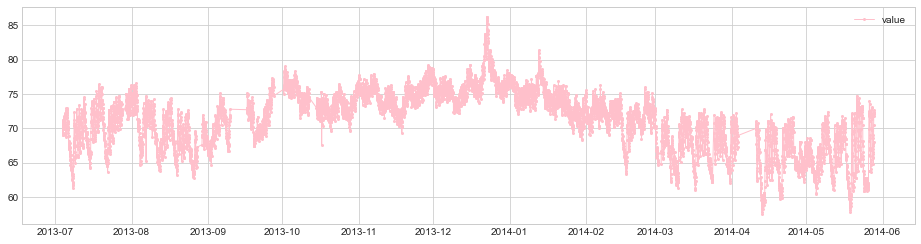

In [17]:
import adtk
from adtk.data import validate_series
from adtk.visualization import plot
df_timeseries = pd.read_csv('ambient_temperature_system_failure.csv', index_col="timestamp", parse_dates=True, squeeze=True)
s = validate_series(df_timeseries)
plot(s, ts_linewidth=1, ts_markersize=4, ts_color = 'pink')
print(df_timeseries.head())

/Users/volkansonmez/miniconda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


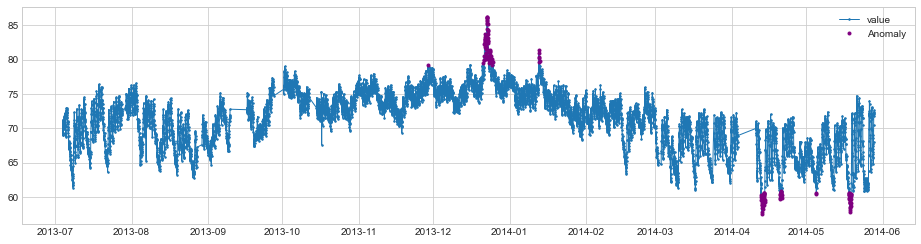

In [18]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=3, anomaly_color='purple', anomaly_tag="marker")

# Conclusion:
# If we only assume the top 1 percent extreme as anomality. We can say that anything over 80 and below 60 is extreme. 

In [19]:
# Since the data has some missing values, it is hard to continue with adtk tools to slide some windows across the data.